In [1]:
from eicvibe.machine_portal.lattice import Lattice
from eicvibe.machine_portal.bend import Bend
from eicvibe.machine_portal.drift import Drift
from eicvibe.machine_portal.quadrupole import Quadrupole
from eicvibe.machine_portal.monitor import Monitor

from eicvibe.simulators.xsuite_interface import XSuiteSimulationEngine
from eicvibe.simulators.types import SimulationMode, ParticleDistribution, DistributionType
import numpy as np

In [2]:
# Define FODO cell - Simplified approach

# Create lattice first
fodo = Lattice(name="FODO")

# Create elements with parameters in one step (using constructor where possible)
d1 = Drift(name="Drift1", length=1.0)
b1 = Bend(name="Bend1", length=2.0)
b1.add_parameter("BendP", "angle", np.pi/10)

b2 = Bend(name="Bend2", length=2.0)
b2.add_parameter("BendP", "angle", np.pi/10)

# Quadrupoles with strength parameter
k = 0.5  # 1/focal_length in m^-1
qf = Quadrupole(name="Quad1", length=0.6)
qf.add_parameter("MagneticMultipoleP", "kn1", -k)
qf.add_parameter("ApertureP", "X", [-0.05, 0.05])

qd = Quadrupole(name="Quad2", length=0.6)
qd.add_parameter("MagneticMultipoleP", "kn1", k)

# Beam position monitors (zero length)
bpm1 = Monitor(name="BPM1")
bpm2 = Monitor(name="BPM2")
bpm3 = Monitor(name="BPM3")
bpm4 = Monitor(name="BPM4")

# Define cell sequence and add as branch in one step
# FODO structure: QF - Drift - BPM - Bend - BPM - Drift - QD - Drift - BPM - Bend - BPM - Drift
cell = [qf, d1, bpm1, b2, bpm2, d1, qd, d1, bpm3, b1, bpm4, d1]

# add_branch automatically adds elements and creates the branch
fodo.add_branch("FODO", cell, branch_type="ring")

print(f"✓ Created FODO lattice with {len(fodo.elements)} unique elements")
print(f"  Branch 'FODO' contains {len(fodo.branches['FODO'])} element instances")

✓ Created FODO lattice with 21 unique elements
  Branch 'FODO' contains 12 element instances


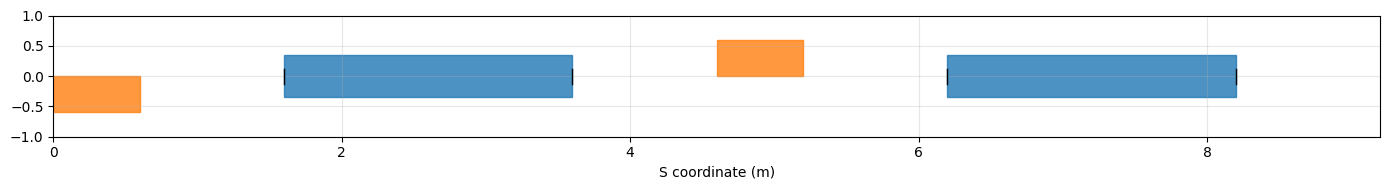

✓ Beamline plot shows:
  - Blue boxes: Quadrupoles (height = magnetic strength)
  - Brown boxes: Dipole bends
  - Green lines: BPMs (beam position monitors)
  - Element positions along s-coordinate


In [3]:
import matplotlib.pyplot as plt

# 1D Beamline Plot - Shows element layout along s-coordinate
fig, ax = plt.subplots(figsize=(14, 2))

# Plot the beamline with default settings
fodo.plot_branch_beamline("FODO", ax=ax, start_s=0.0, normalized_strength=None)

plt.tight_layout()
plt.show()

print("✓ Beamline plot shows:")
print("  - Blue boxes: Quadrupoles (height = magnetic strength)")
print("  - Brown boxes: Dipole bends")
print("  - Green lines: BPMs (beam position monitors)")
print("  - Element positions along s-coordinate")

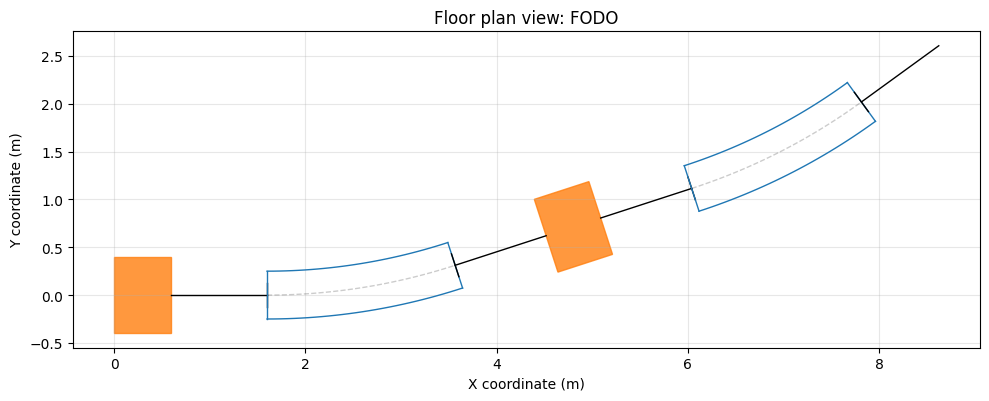

✓ Floor plan shows:
  - Actual beam trajectory including bend deflections
  - Physical element positions in x-z plane
  - Ring closure (should form closed loop for ring topology)
  - Space requirements for the accelerator


In [4]:
# 2D Floor Plan - Shows physical layout with bending trajectory
fig, ax = plt.subplots(figsize=(10, 10))
ax.set_aspect('equal')  # Important: maintain aspect ratio for accurate geometry

# Plot the floor plan
fodo.plot_branch_floorplan("FODO", ax=ax)

plt.tight_layout()
plt.show()

print("✓ Floor plan shows:")
print("  - Actual beam trajectory including bend deflections")
print("  - Physical element positions in x-z plane")
print("  - Ring closure (should form closed loop for ring topology)")
print("  - Space requirements for the accelerator")

## Step 2: Initialize Virtual Accelerator

Now we'll set up the simulation engine to create a "virtual accelerator" from the lattice design.

In [5]:
# Create and initialize simulation engine
engine = XSuiteSimulationEngine()

# Initialize engine explicitly (creates computation context)
if not engine.initialize_engine():
    raise RuntimeError("Failed to initialize XSuite engine")

# Convert lattice with reference particle setup (IMPROVED API)
xsuite_line = engine.convert_lattice(
    fodo, 
    mode=SimulationMode.RING,
    reference_energy=18e9,       # 18 GeV proton beam
    reference_species="proton",  # Particle type
    bpm_num_turns=500,           # BPM recording duration (turns)
    bpm_frev=1e6                 # Revolution frequency (Hz)
)

print(f"✓ Virtual accelerator initialized")
print(f"  Total length: {xsuite_line.get_length():.2f} m")
print(f"  Number of elements: {len(xsuite_line.element_names)}")
print(f"  Simulation mode: RING")
print(f"  Reference particle: {xsuite_line.particle_ref.p0c[0]/1e9:.2f} GeV proton")

Slicing line:   0%|          | 0/12 [00:00<?, ?it/s]

✓ Virtual accelerator initialized
  Total length: 9.20 m
  Number of elements: 828
  Simulation mode: RING
  Reference particle: 18.00 GeV proton


In [6]:
fodo.get_total_path_length()

9.2

In [7]:
xsdict=xsuite_line.to_dict()
xsdict

{'__class__': 'Line',
 'elements': {'Quad1_1': {'__class__': 'Quadrupole',
   'order': np.int64(5),
   'length': np.float64(0.6),
   'k1': np.float64(-0.5)},
  'Drift1_1': {'__class__': 'Drift', 'length': np.float64(1.0)},
  'BPM1_1': {'__class__': 'BeamPositionMonitor',
   'frev': np.float64(1000000.0),
   'stop_at_turn': np.int64(500),
   'sampling_frequency': np.float64(1000000.0),
   '_index': {'capacity': np.int64(0),
    'num_recorded': np.uint32(0),
    '_dummy': np.uint32(0),
    'buffer_id': np.int64(0)},
   'num_particles': np.int64(-1),
   'data': {'count': [np.float64(0.0),
     np.float64(0.0),
     np.float64(0.0),
     np.float64(0.0),
     np.float64(0.0),
     np.float64(0.0),
     np.float64(0.0),
     np.float64(0.0),
     np.float64(0.0),
     np.float64(0.0),
     np.float64(0.0),
     np.float64(0.0),
     np.float64(0.0),
     np.float64(0.0),
     np.float64(0.0),
     np.float64(0.0),
     np.float64(0.0),
     np.float64(0.0),
     np.float64(0.0),
     np.flo

In [8]:
# Calculate Twiss parameters (optics functions)
# Now possible because reference particle is set!
from eicvibe import TwissData, SimulationMode
import numpy as np

# Get raw XSuite twiss result
xsuite_twiss = xsuite_line.twiss(method='4d')

# Convert to EICViBE package-level TwissData structure
twiss = TwissData(
    s=xsuite_twiss.s,
    beta_x=xsuite_twiss.betx,
    beta_y=xsuite_twiss.bety,
    alpha_x=xsuite_twiss.alfx,
    alpha_y=xsuite_twiss.alfy,
    gamma_x=xsuite_twiss.gamx,
    gamma_y=xsuite_twiss.gamy,
    dx=xsuite_twiss.dx,
    dy=xsuite_twiss.dy,
    dpx=xsuite_twiss.dpx,
    dpy=xsuite_twiss.dpy,
    tune_x=xsuite_twiss.qx,
    tune_y=xsuite_twiss.qy,
    momentum_compaction=xsuite_twiss.momentum_compaction_factor,
    simulation_mode=SimulationMode.RING,
    reference_energy=18e9,
    engine_name="XSuite",
    computation_method="4d"
)

# Display key optics parameters using TwissData
print("✓ Twiss parameters calculated and converted to EICViBE TwissData")
print(f"\nPeriodic solution (RING mode):")
print(f"  Tune X: {twiss.tune_x:.4f}")
print(f"  Tune Y: {twiss.tune_y:.4f}")
print(f"  Momentum compaction: {twiss.momentum_compaction:.6f}")
print(f"\nBeta functions at start:")
print(f"  βx = {twiss.beta_x[0]:.2f} m")
print(f"  βy = {twiss.beta_y[0]:.2f} m")
print(f"\nMax beta functions:")
print(f"  max(βx) = {np.max(twiss.beta_x):.2f} m")
print(f"  max(βy) = {np.max(twiss.beta_y):.2f} m")
print(f"\nData source: {twiss.engine_name} ({twiss.computation_method} method)")

✓ Twiss parameters calculated and converted to EICViBE TwissData

Periodic solution (RING mode):
  Tune X: 0.2833
  Tune Y: 0.2292
  Momentum compaction: 0.141813

Beta functions at start:
  βx = 2.51 m
  βy = 14.50 m

Max beta functions:
  max(βx) = 13.30 m
  max(βy) = 15.18 m

Data source: XSuite (4d method)


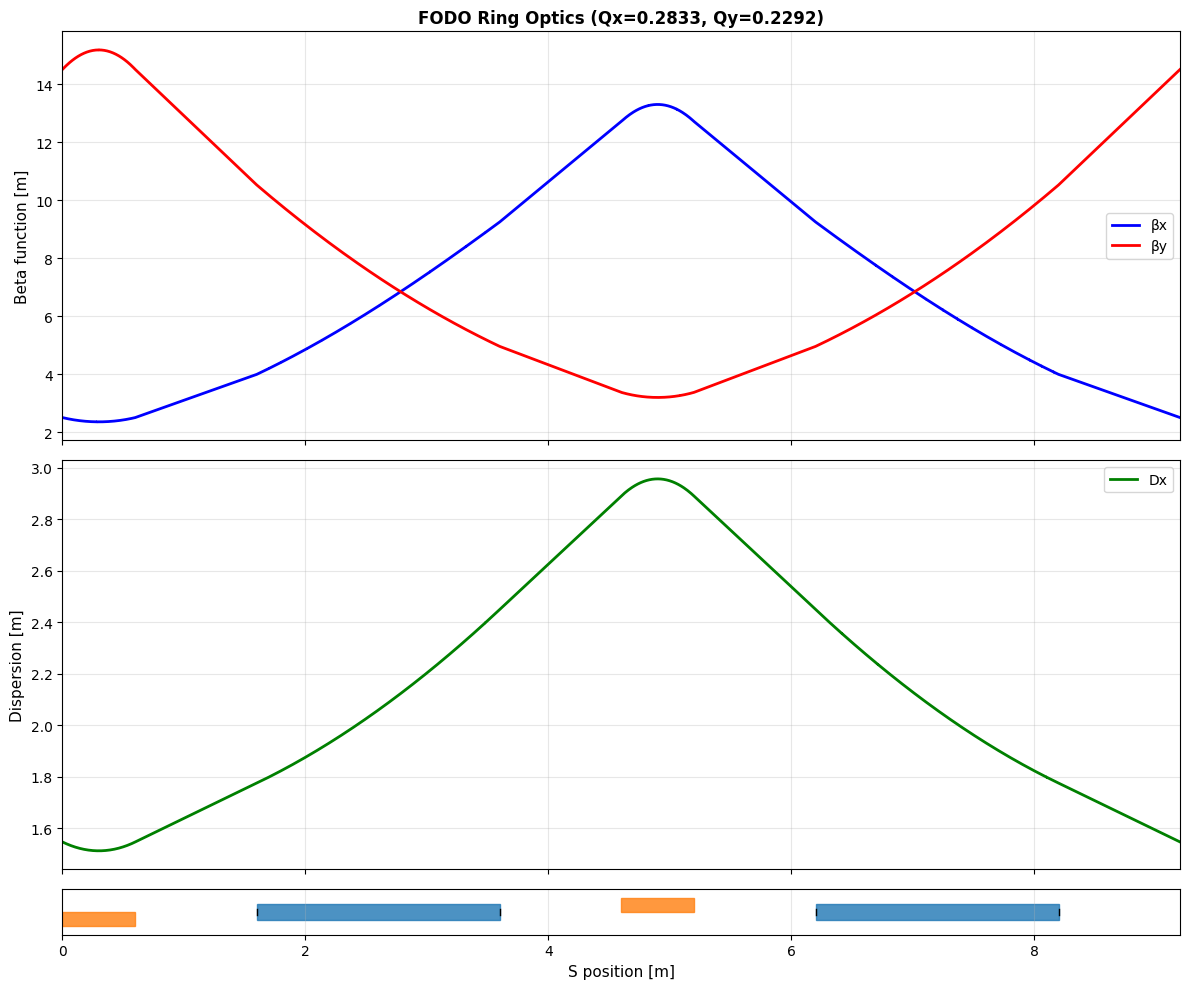

In [9]:
# Plot beta functions, dispersion, and lattice layout
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(12, 10), 
                                     gridspec_kw={'height_ratios': [9, 9, 1]},
                                     sharex=True)

# Beta functions
ax1.plot(twiss.s, twiss.betx, 'b-', label='βx', linewidth=2)
ax1.plot(twiss.s, twiss.bety, 'r-', label='βy', linewidth=2)
ax1.set_ylabel('Beta function [m]', fontsize=11)
ax1.legend(loc='best', fontsize=10)
ax1.grid(True, alpha=0.3)
ax1.set_title(f'FODO Ring Optics (Qx={twiss.qx:.4f}, Qy={twiss.qy:.4f})', fontsize=12, fontweight='bold')

# Dispersion
ax2.plot(twiss.s, twiss.dx, 'g-', label='Dx', linewidth=2)
ax2.set_ylabel('Dispersion [m]', fontsize=11)
ax2.legend(loc='best', fontsize=10)
ax2.grid(True, alpha=0.3)

# Lattice layout (beamline)
fodo.plot_branch_beamline("FODO", ax=ax3, start_s=0.0, normalized_strength=None)
ax3.set_xlabel('S position [m]', fontsize=11)
ax3.set_yticks([])  # Remove y-axis ticks
ax3.set_ylabel('')  # Remove y-axis label

plt.tight_layout()
plt.show()

In [10]:
# Generate matched particle distribution using ParticleDistribution
# SIMPLIFIED VERSION: Pass TwissData directly instead of individual parameters

# Method 1: Simplified - just pass TwissData object (recommended)
# This automatically extracts ALL Twiss parameters including dx, dy, dpx, dpy
particle_dist = ParticleDistribution.from_twiss(
    twiss=twiss,              # TwissData object automatically provides all Twiss parameters
    num_particles=10000,
    emittance_x=1e-9,         # m·rad (geometric emittance)
    emittance_y=1e-9,         # m·rad
    zeta_std=1e-2,            # 1 cm RMS bunch length
    delta_std=1e-3,           # 0.1% momentum spread
    s_position=0.0,           # Extract Twiss parameters at s=0 (default)
    x_mean=0.0,               # Centered beam
    y_mean=0.0
)

# Method 2: Explicit (original way - still supported for custom control)
# Shows ALL dispersion components for proper matching
# particle_dist = ParticleDistribution(
#     distribution_type=DistributionType.GAUSSIAN,
#     num_particles=10000,
#     energy=18e9,
#     emittance_x=1e-9,
#     emittance_y=1e-9,
#     beta_x=twiss.betx[0],      # Manually extract from TwissData
#     beta_y=twiss.bety[0],
#     alpha_x=twiss.alfx[0],
#     alpha_y=twiss.alfy[0],
#     dx=twiss.dx[0],            # Horizontal dispersion
#     dy=twiss.dy[0],            # Vertical dispersion (important for coupled systems)
#     dpx=twiss.dpx[0],          # Horizontal dispersion derivative
#     dpy=twiss.dpy[0],          # Vertical dispersion derivative
#     x_mean=0.0,
#     y_mean=0.0,
#     zeta_std=1e-2,
#     delta_std=1e-3
# )

# Create particles using EICViBE engine
particles = engine.create_particles(particle_dist)

print(f"✓ Created {particle_dist.num_particles} particles using simplified from_twiss() method")
print(f"  Matched to Twiss parameters at s={0.0:.2f} m")
print(f"  βx={twiss.betx[0]:.2f} m, βy={twiss.bety[0]:.2f} m")
print(f"  Dx={twiss.dx[0]:.3f} m, Dy={twiss.dy[0]:.3f} m")
print(f"  D'x={twiss.dpx[0]:.3f}, D'y={twiss.dpy[0]:.3f}")

✓ Created 10000 particles using simplified from_twiss() method
  Matched to Twiss parameters at s=0.00 m
  βx=2.51 m, βy=14.50 m
  Dx=1.547 m, Dy=-0.000 m
  D'x=-0.229, D'y=-0.000


In [11]:
# Save initial particle coordinates for comparison
initial_x = particles.x.copy()
initial_px = particles.px.copy()
initial_y = particles.y.copy()
initial_py = particles.py.copy()

print(f"✓ Saved initial particle coordinates")
print(f"  Initial σx = {np.std(initial_x)*1e3:.3f} mm")
print(f"  Initial σy = {np.std(initial_y)*1e3:.3f} mm")

✓ Saved initial particle coordinates
  Initial σx = 1.542 mm
  Initial σy = 0.122 mm


In [12]:
# Perform multi-turn tracking
num_turns = 100

print(f"Starting tracking for {num_turns} turns...")
xsuite_line.track(particles, num_turns=num_turns)

print(f"✓ Tracking completed")
print(f"  Survived particles: {np.sum(particles.state > 0)}/{len(particles.x)}")
print(f"  Final σx = {np.std(particles.x[particles.state > 0])*1e3:.3f} mm")
print(f"  Final σy = {np.std(particles.y[particles.state > 0])*1e3:.3f} mm")

Starting tracking for 100 turns...
✓ Tracking completed
  Survived particles: 10000/10000
  Final σx = 1.541 mm
  Final σy = 0.120 mm


In [13]:
# Extract BPM data from monitors
# Get BPM elements and their s-positions
bpm_names = [name for name in xsuite_line.element_names if 'BPM' in name]
bpm_positions = [xsuite_line.get_s_position(name) for name in bpm_names]

print(f"✓ Found {len(bpm_names)} BPMs in lattice")
print(f"  BPM positions (s): {[f'{s:.2f}m' for s in bpm_positions]}")

# Extract BPM data turn-by-turn
# XSuite BPMs store data in x_mean/y_mean arrays, not data['x']/data['y']
bpm_data = {}
for bpm_name in bpm_names:
    bpm_element = xsuite_line[bpm_name]
    # Check if BPM has recorded data
    if hasattr(bpm_element, 'x_mean') and hasattr(bpm_element, 'y_mean'):
        bpm_data[bpm_name] = {
            'x': bpm_element.x_mean,  # XSuite API: x_mean array
            'y': bpm_element.y_mean,  # XSuite API: y_mean array
            's': xsuite_line.get_s_position(bpm_name)
        }

if len(bpm_data) == 0:
    print("⚠ No BPM data available - BPMs may not have been triggered during tracking")
else:
    print(f"✓ Extracted BPM data from {len(bpm_data)} monitors")
    for name, data in bpm_data.items():
        print(f"  {name}: {len(data['x'])} turn readings")

✓ Found 4 BPMs in lattice
  BPM positions (s): ['1.60m', '3.60m', '6.20m', '8.20m']
✓ Extracted BPM data from 4 monitors
  BPM1_1: 500 turn readings
  BPM2_1: 500 turn readings
  BPM3_1: 500 turn readings
  BPM4_1: 500 turn readings


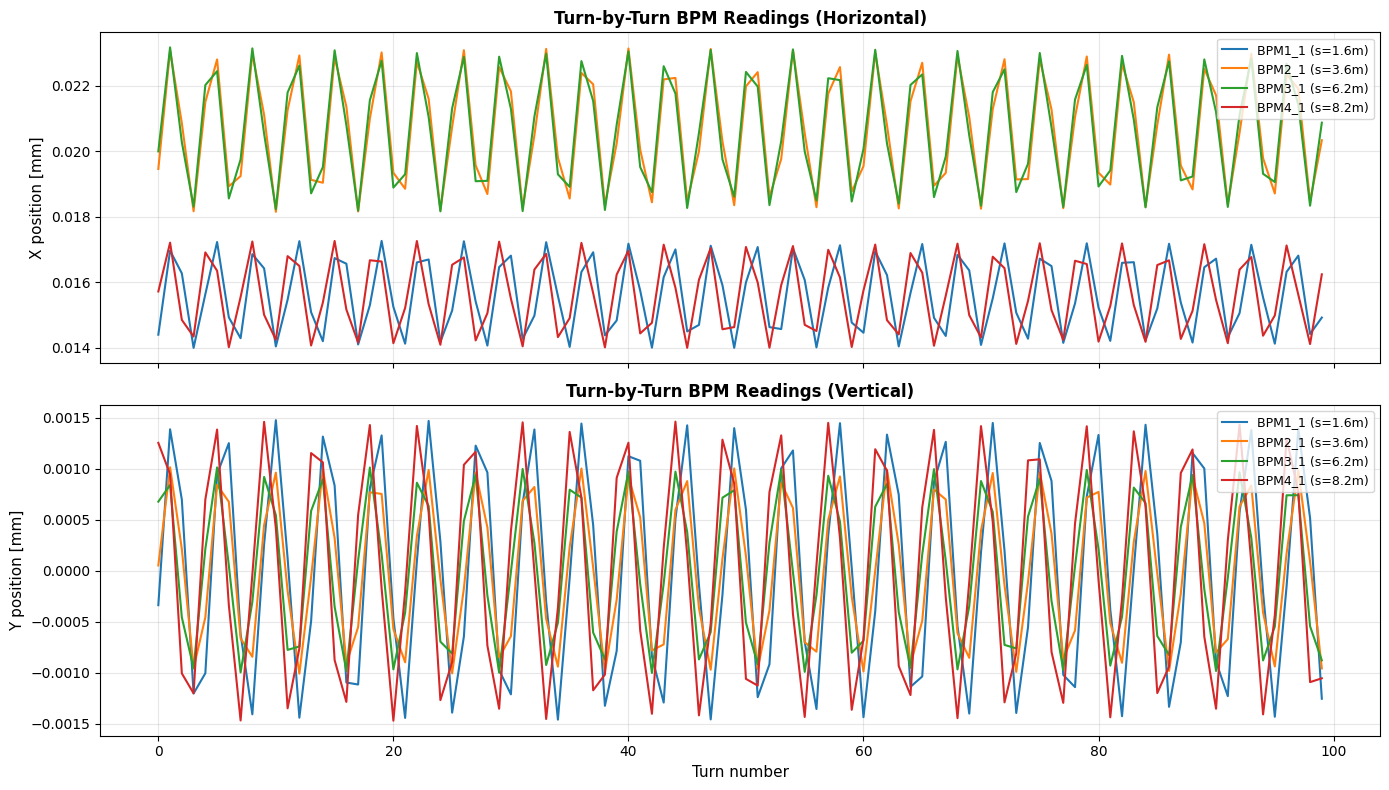

✓ BPM readings show beam position evolution over turns


In [14]:
# Visualize turn-by-turn BPM readings
fig, axes = plt.subplots(2, 1, figsize=(14, 8), sharex=True)

# Plot horizontal position vs turn for each BPM
ax = axes[0]
for bpm_name in sorted(bpm_data.keys()):
    data = bpm_data[bpm_name]
    turns = np.arange(len(data['x']))
    # Plot mean position per turn
    x_mean = np.mean(data['x'], axis=1) if len(data['x'].shape) > 1 else data['x']
    ax.plot(turns, x_mean * 1e3, label=f"{bpm_name} (s={data['s']:.1f}m)", linewidth=1.5)

ax.set_ylabel('X position [mm]', fontsize=11)
ax.legend(loc='best', fontsize=9)
ax.grid(True, alpha=0.3)
ax.set_title('Turn-by-Turn BPM Readings (Horizontal)', fontsize=12, fontweight='bold')

# Plot vertical position vs turn for each BPM
ax = axes[1]
for bpm_name in sorted(bpm_data.keys()):
    data = bpm_data[bpm_name]
    turns = np.arange(len(data['y']))
    # Plot mean position per turn
    y_mean = np.mean(data['y'], axis=1) if len(data['y'].shape) > 1 else data['y']
    ax.plot(turns, y_mean * 1e3, label=f"{bpm_name} (s={data['s']:.1f}m)", linewidth=1.5)

ax.set_xlabel('Turn number', fontsize=11)
ax.set_ylabel('Y position [mm]', fontsize=11)
ax.legend(loc='best', fontsize=9)
ax.grid(True, alpha=0.3)
ax.set_title('Turn-by-Turn BPM Readings (Vertical)', fontsize=12, fontweight='bold')

plt.tight_layout()
plt.show()

print("✓ BPM readings show beam position evolution over turns")

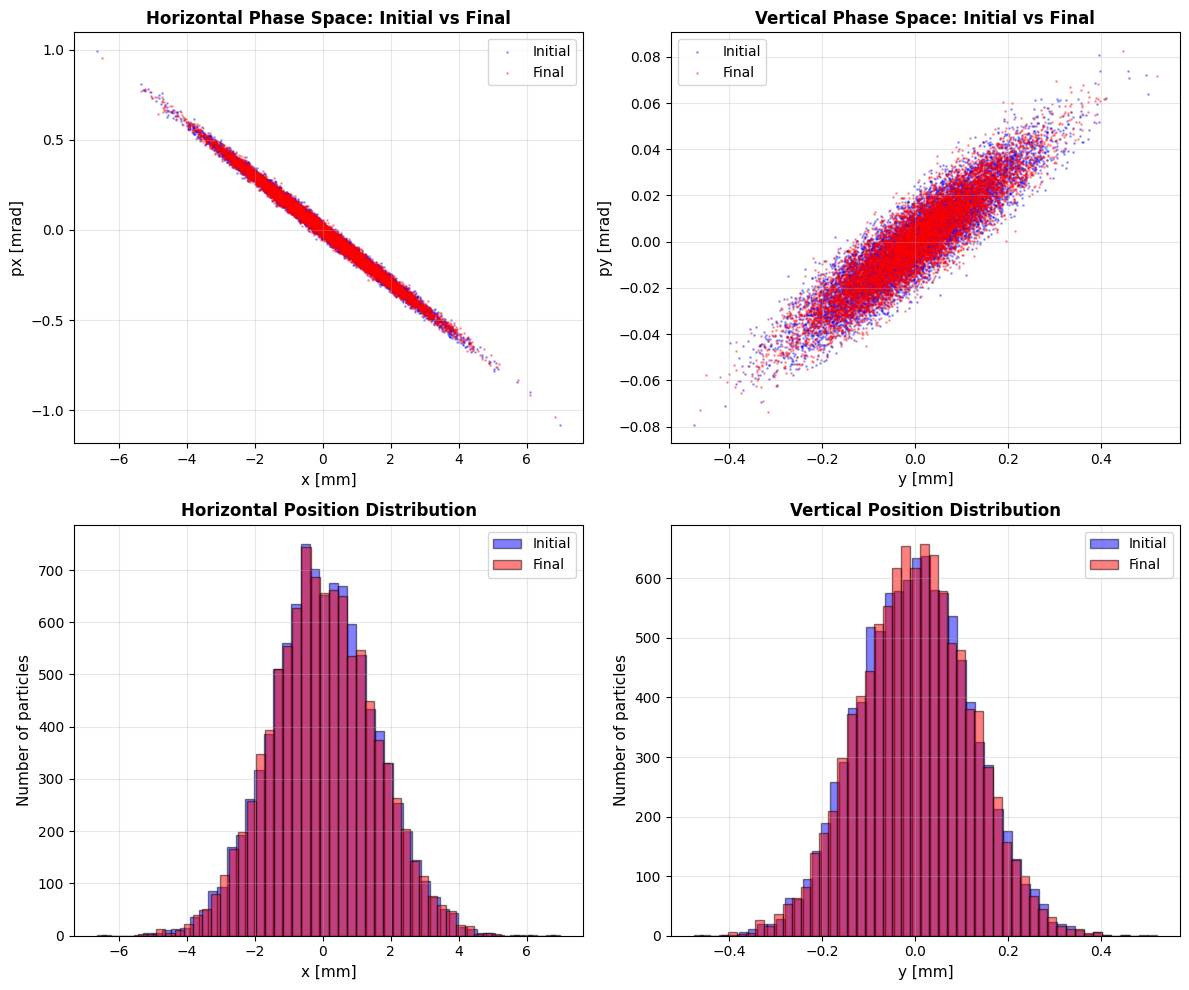


✓ Phase space comparison after 100 turns:

Initial beam:
  σx = 1.542 mm,  σpx = 0.229 mrad
  σy = 0.122 mm,  σpy = 0.020 mrad

Final beam (surviving particles):
  σx = 1.541 mm,  σpx = 0.228 mrad
  σy = 0.120 mm,  σpy = 0.020 mrad

Emittance preservation:
  ε_x change: -0.24%
  ε_y change: -0.98%


In [15]:
# Compare initial vs final phase space
fig, axes = plt.subplots(2, 2, figsize=(12, 10))

# Filter surviving particles
alive = particles.state > 0

# X-Px phase space comparison
ax = axes[0, 0]
ax.scatter(initial_x * 1e3, initial_px * 1e3, s=1, alpha=0.3, label='Initial', color='blue')
ax.scatter(particles.x[alive] * 1e3, particles.px[alive] * 1e3, s=1, alpha=0.3, label='Final', color='red')
ax.set_xlabel('x [mm]', fontsize=11)
ax.set_ylabel('px [mrad]', fontsize=11)
ax.set_title('Horizontal Phase Space: Initial vs Final', fontsize=12, fontweight='bold')
ax.legend(fontsize=10)
ax.grid(True, alpha=0.3)

# Y-Py phase space comparison
ax = axes[0, 1]
ax.scatter(initial_y * 1e3, initial_py * 1e3, s=1, alpha=0.3, label='Initial', color='blue')
ax.scatter(particles.y[alive] * 1e3, particles.py[alive] * 1e3, s=1, alpha=0.3, label='Final', color='red')
ax.set_xlabel('y [mm]', fontsize=11)
ax.set_ylabel('py [mrad]', fontsize=11)
ax.set_title('Vertical Phase Space: Initial vs Final', fontsize=12, fontweight='bold')
ax.legend(fontsize=10)
ax.grid(True, alpha=0.3)

# X position evolution (initial vs final distribution)
ax = axes[1, 0]
ax.hist(initial_x * 1e3, bins=50, alpha=0.5, label='Initial', color='blue', edgecolor='black')
ax.hist(particles.x[alive] * 1e3, bins=50, alpha=0.5, label='Final', color='red', edgecolor='black')
ax.set_xlabel('x [mm]', fontsize=11)
ax.set_ylabel('Number of particles', fontsize=11)
ax.set_title('Horizontal Position Distribution', fontsize=12, fontweight='bold')
ax.legend(fontsize=10)
ax.grid(True, alpha=0.3)

# Y position evolution (initial vs final distribution)
ax = axes[1, 1]
ax.hist(initial_y * 1e3, bins=50, alpha=0.5, label='Initial', color='blue', edgecolor='black')
ax.hist(particles.y[alive] * 1e3, bins=50, alpha=0.5, label='Final', color='red', edgecolor='black')
ax.set_xlabel('y [mm]', fontsize=11)
ax.set_ylabel('Number of particles', fontsize=11)
ax.set_title('Vertical Position Distribution', fontsize=12, fontweight='bold')
ax.legend(fontsize=10)
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Print comparison statistics
print(f"\n✓ Phase space comparison after {num_turns} turns:")
print(f"\nInitial beam:")
print(f"  σx = {np.std(initial_x)*1e3:.3f} mm,  σpx = {np.std(initial_px)*1e3:.3f} mrad")
print(f"  σy = {np.std(initial_y)*1e3:.3f} mm,  σpy = {np.std(initial_py)*1e3:.3f} mrad")
print(f"\nFinal beam (surviving particles):")
print(f"  σx = {np.std(particles.x[alive])*1e3:.3f} mm,  σpx = {np.std(particles.px[alive])*1e3:.3f} mrad")
print(f"  σy = {np.std(particles.y[alive])*1e3:.3f} mm,  σpy = {np.std(particles.py[alive])*1e3:.3f} mrad")
print(f"\nEmittance preservation:")
print(f"  ε_x change: {(np.std(particles.x[alive])*np.std(particles.px[alive]) / (np.std(initial_x)*np.std(initial_px)) - 1)*100:.2f}%")
print(f"  ε_y change: {(np.std(particles.y[alive])*np.std(particles.py[alive]) / (np.std(initial_y)*np.std(initial_py)) - 1)*100:.2f}%")

## Step 4: Interactive Visualization GUI

EICViBE provides an interactive GUI for visualizing lattices, Twiss parameters, and BPM data. The GUI can be launched from notebooks or terminals.

In [16]:
# Option 1: Notebook-friendly viewer (matplotlib-based, works inline)
from eicvibe.visualization import create_notebook_viewer

# Engine-agnostic interface: pass EICViBE lattice and results from simulation engine
# The Twiss data is a package-level standard (eicvibe.optics.TwissData)
# that any engine can populate - XSuite, MAD-X, Elegant, future engines
viewer = create_notebook_viewer(
    lattice=fodo,        # EICViBE Lattice object
    twiss=twiss,         # TwissData from any engine (this one from XSuite)
    bpm_data=bpm_data,   # BPM data dictionary
    branch_name="FODO"
)

# Display all plots in a single view
viewer.show_all()

In [17]:
# Option 2: Standalone GUI window (PyQt5-based, works in notebooks and terminal)
# Note: Requires PyQt5 to be installed: uv add PyQt5 --optional visualization

# Suppress matplotlib output and clear all figures
import matplotlib.pyplot as plt
plt.ioff()  # Turn off interactive mode
plt.close('all')  # Close all existing figures

# Clear notebook output
from IPython.display import clear_output
clear_output(wait=True)

# For macOS + Jupyter: Enable Qt event loop integration
try:
    get_ipython().run_line_magic('gui', 'qt5')
    print("✓ Qt event loop enabled")
except:
    pass

# Force reload to get latest fixes
import importlib
import sys
if 'eicvibe.visualization.gui_app' in sys.modules:
    importlib.reload(sys.modules['eicvibe.visualization.gui_app'])
if 'eicvibe.visualization' in sys.modules:
    importlib.reload(sys.modules['eicvibe.visualization'])

from eicvibe.visualization import GUI_AVAILABLE

if GUI_AVAILABLE:
    from PyQt5.QtWidgets import QApplication
    from eicvibe.visualization.gui_app import LatticeViewerGUI
    
    # Create QApplication if needed
    app = QApplication.instance()
    if app is None:
        app = QApplication(sys.argv)
    
    # Create window directly
    window = LatticeViewerGUI(
        lattice=fodo,        # EICViBE Lattice object
        twiss=twiss,         # Twiss results from any engine
        bpm_data=bpm_data,   # BPM data dictionary
        branch_name="FODO"
    )
    
    # macOS-specific: Activate application and bring to front
    window.show()
    window.raise_()
    window.activateWindow()
    app.processEvents()  # Process pending events to force display
    
    print("✓ GUI window launched (separate window)")
    print("  - GUI works at EICViBE level, reads results from any engine")
    print("  - Use tabs to switch between views")
    print("  - Toggle 'BPM vs S' checkbox to change BPM plot mode")
    print("  - Click 'Refresh All' to update plots")
    print("\n⚠ Note: Keep this notebook kernel running to interact with the GUI")
else:
    print("⚠ PyQt5 not available. Install with: uv add PyQt5 --optional visualization")
    print("  Using notebook viewer instead:")
    viewer.show_beamline()

✓ Qt event loop enabled


/Users/haoyue/src/EICViBE/src/eicvibe/visualization/lattice_viewer.py:270: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  self.fig.tight_layout()
/Users/haoyue/src/EICViBE/src/eicvibe/visualization/lattice_viewer.py:71: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  self.fig.tight_layout()


✓ GUI window launched (separate window)
  - GUI works at EICViBE level, reads results from any engine
  - Use tabs to switch between views
  - Toggle 'BPM vs S' checkbox to change BPM plot mode
  - Click 'Refresh All' to update plots

⚠ Note: Keep this notebook kernel running to interact with the GUI


### Individual Plot Access

You can also display individual plots using the notebook viewer:

In [18]:
# Display individual plots
# viewer.show_beamline()  # Beamline layout only
# viewer.show_floorplan()  # Floor plan only
# viewer.show_twiss()      # Twiss parameters only
# viewer.show_bpm(plot_vs_turn=True)   # BPM vs turn
# viewer.show_bpm(plot_vs_turn=False)  # BPM vs s position

print("✓ Uncomment any line above to show individual plots")

✓ Uncomment any line above to show individual plots
